<a href="https://colab.research.google.com/github/anshuman-sahoo1999/BMI-Calculator-by-using-python/blob/main/braintumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coupling the Fisher–Kolmogorov Reaction–Diffusion Equation with Deep Learning for Data-Driven Forecasting of Brain Tumor Dynamics

Author:
Anshuman Sahoo,
M. Tech CSE Student,
Department of CSE, DRIEMS university

In [5]:
# (shell cell)
get_ipython().system('nvidia-smi || echo "No GPU found. Go to Runtime -> Change runtime type -> GPU"')
get_ipython().system('python -V')

/bin/bash: line 1: nvidia-smi: command not found
No GPU found. Go to Runtime -> Change runtime type -> GPU
Python 3.12.12


In [6]:
# installs (run once)
!pip install -q kaggle==1.5.12
!pip install -q torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118
!pip install -q albumentations==1.3.1 opencv-python-headless matplotlib tqdm SimpleITK

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Instructions:
# 1) On Kaggle: My Account -> Create API Token -> download kaggle.json
# 2) Upload it via the Colab file upload prompt below

from google.colab import files
uploaded = files.upload()  # upload kaggle.json

Saving kaggle.json to kaggle.json


In [8]:
!mkdir -p /root/.kaggle
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [9]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection -q
!unzip -q brain-mri-images-for-brain-tumor-detection.zip -d /content/data
get_ipython().system('ls -lah /content/data')

total 20K
drwxr-xr-x 5 root root 4.0K Oct 27 04:21 .
drwxr-xr-x 1 root root 4.0K Oct 27 04:21 ..
drwxr-xr-x 4 root root 4.0K Oct 27 04:21 brain_tumor_dataset
drwxr-xr-x 2 root root 4.0K Oct 27 04:21 no
drwxr-xr-x 2 root root 4.0K Oct 27 04:21 yes


In [10]:
import os
os.makedirs('/content/project/checkpoints', exist_ok=True)
os.makedirs('/content/project/plots', exist_ok=True)
os.makedirs('/content/project/viz', exist_ok=True)
os.makedirs('/content/project/outputs', exist_ok=True)
DATA_DIR = '/content/data'

Found 346 images (showing 5):
/content/data/no/no 97.jpg
/content/data/no/N17.jpg
/content/data/no/29 no.jpg
/content/data/no/30 no.jpg
/content/data/no/36 no.jpg


(np.float64(-0.5), np.float64(441.5), np.float64(441.5), np.float64(-0.5))

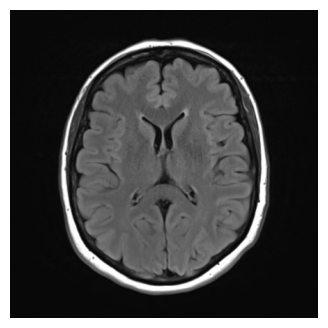

In [11]:
import glob, cv2, numpy as np, matplotlib.pyplot as plt
img_list = glob.glob(DATA_DIR + '/**/*.jpg', recursive=True) + glob.glob(DATA_DIR + '/**/*.png', recursive=True)
print(f"Found {len(img_list)} images (showing 5):")
for p in img_list[:5]:
    print(p)
# display sample
img = cv2.imread(img_list[0], cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(4,4)); plt.imshow(img, cmap='gray'); plt.axis('off')

Found 358 source image files under /content/data (first 10 shown):
  /content/data/brain_tumor_dataset/no/1 no.jpeg
  /content/data/brain_tumor_dataset/no/10 no.jpg
  /content/data/brain_tumor_dataset/no/11 no.jpg
  /content/data/brain_tumor_dataset/no/12 no.jpg
  /content/data/brain_tumor_dataset/no/13 no.jpg
  /content/data/brain_tumor_dataset/no/14 no.jpg
  /content/data/brain_tumor_dataset/no/15 no.jpg
  /content/data/brain_tumor_dataset/no/17 no.jpg
  /content/data/brain_tumor_dataset/no/18 no.jpg
  /content/data/brain_tumor_dataset/no/19 no.jpg
Created 358 image+mask pairs in:
 - images: /content/project
 - masks: /content/project/masks
Example files: /content/project/img_0000.png /content/project/masks/mask_0000.png


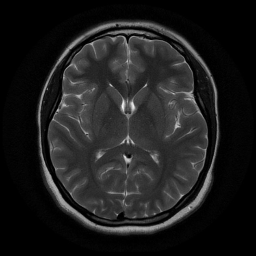

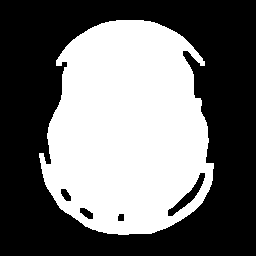

In [12]:
# Robust synthetic mask creation: handles jpg/png/jpeg and skips problematic files.
import os, glob, cv2, numpy as np

SRC_DIR = '/content/data'   # change if your images are elsewhere
OUT_IMG_DIR = '/content/project'
MASK_DIR = '/content/project/masks'
os.makedirs(OUT_IMG_DIR, exist_ok=True)
os.makedirs(MASK_DIR, exist_ok=True)

# collect images with common extensions
img_extensions = ('*.png','*.jpg','*.jpeg','*.tif','*.bmp')
img_paths = []
for ext in img_extensions:
    img_paths.extend(glob.glob(os.path.join(SRC_DIR, '**', ext), recursive=True))
img_paths = sorted(list(set(img_paths)))

print(f"Found {len(img_paths)} source image files under {SRC_DIR} (first 10 shown):")
for p in img_paths[:10]:
    print(" ", p)

if len(img_paths) == 0:
    raise SystemExit("No images found under /content/data — please check DATA_DIR path or upload images.")

def create_mask(img):
    # If image is mostly dark, use Otsu threshold as-is; otherwise invert after threshold.
    blur = cv2.GaussianBlur(img, (5,5), 0)
    _, th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # heuristics: ensure mask highlights bright-ish tumor region
    if np.mean(img) < 128:
        mask = th
    else:
        mask = 255 - th
    # morphological ops to clean
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    # keep largest connected component
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats((mask>127).astype('uint8'), connectivity=8)
    if num_labels <= 1:
        return mask
    areas = stats[1:, cv2.CC_STAT_AREA]
    largest_idx = 1 + int(np.argmax(areas))
    out = (labels == largest_idx).astype('uint8')*255
    return out

created = 0
for i, src in enumerate(img_paths):
    try:
        img = cv2.imread(src, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print("Skipping unreadable:", src)
            continue
        img = cv2.resize(img, (256,256))
        mask = create_mask(img)
        out_img_p = os.path.join(OUT_IMG_DIR, f"img_{i:04d}.png")
        out_mask_p = os.path.join(MASK_DIR, f"mask_{i:04d}.png")
        cv2.imwrite(out_img_p, img)
        cv2.imwrite(out_mask_p, mask)
        created += 1
    except Exception as e:
        print("Error processing", src, str(e))
print(f"Created {created} image+mask pairs in:\n - images: {OUT_IMG_DIR}\n - masks: {MASK_DIR}")
# show first example
if created>0:
    example_img = os.path.join(OUT_IMG_DIR, "img_0000.png")
    example_mask = os.path.join(MASK_DIR, "mask_0000.png")
    from IPython.display import Image, display
    print("Example files:", example_img, example_mask)
    display(Image(example_img))
    display(Image(example_mask))

Found 358 t0 masks in /content/project/masks
Created 358 synthetic t1 masks in /content/project/masks_t1
Example t0 and t1:


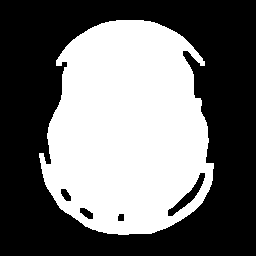

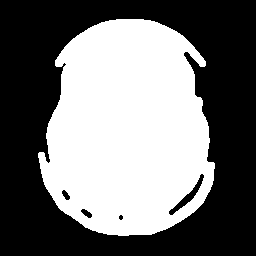

In [13]:
import glob, cv2, os
MASK_DIR = '/content/project/masks'
FUT_DIR = '/content/project/masks_t1'
os.makedirs(FUT_DIR, exist_ok=True)

mask_paths = sorted(glob.glob(os.path.join(MASK_DIR, 'mask_*.png')))
print("Found", len(mask_paths), "t0 masks in", MASK_DIR)
if len(mask_paths) == 0:
    raise SystemExit("No masks found in the original mask directory. Please run the mask creation cell above.")

created = 0
for p in mask_paths:
    m = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
    if m is None:
        continue
    # simulate growth with slightly randomized kernel & iterations to create variability
    ksize = 3 + (created % 3)*2
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (ksize,ksize))
    iterations = 1 + (created % 3)
    grown = cv2.dilate(m, kernel, iterations=iterations)
    grown = cv2.GaussianBlur(grown, (5,5), 0)
    _, grown_bin = cv2.threshold(grown, 127, 255, cv2.THRESH_BINARY)
    fname = os.path.basename(p).replace('mask_', 'mask_t1_')
    outp = os.path.join(FUT_DIR, fname)
    cv2.imwrite(outp, grown_bin)
    created += 1

print(f"Created {created} synthetic t1 masks in {FUT_DIR}")
# show example pair if created
if created>0:
    from IPython.display import Image, display
    print("Example t0 and t1:")
    display(Image(mask_paths[0]))
    display(Image(os.path.join(FUT_DIR, os.path.basename(mask_paths[0]).replace('mask_','mask_t1_'))))


In [14]:
# Cell 8: Dataset & DataLoader
import torch, cv2, numpy as np, glob, os
from torch.utils.data import Dataset, DataLoader

class TumorTimeDataset(Dataset):
    def __init__(self, img_dir, mask_dir_t0, mask_dir_t1, transform=None):
        self.imgs = sorted(glob.glob(os.path.join(img_dir, 'img_*.png')))
        self.masks_t0 = sorted(glob.glob(os.path.join(mask_dir_t0, 'mask_*.png')))
        self.masks_t1 = sorted(glob.glob(os.path.join(mask_dir_t1, 'mask_t1_*.png')))
        assert len(self.imgs)>0, f"No images found in {img_dir}"
        assert len(self.masks_t0)>0, f"No t0 masks found in {mask_dir_t0}"
        assert len(self.masks_t1)>0, f"No t1 masks found in {mask_dir_t1}"
        # ensure equal lengths by truncating to shortest
        n = min(len(self.imgs), len(self.masks_t0), len(self.masks_t1))
        self.imgs = self.imgs[:n]
        self.masks_t0 = self.masks_t0[:n]
        self.masks_t1 = self.masks_t1[:n]
        self.transform = transform

    def __len__(self): return len(self.imgs)

    def __getitem__(self, idx):
        img = cv2.imread(self.imgs[idx], cv2.IMREAD_GRAYSCALE).astype('float32')/255.0
        m0 = cv2.imread(self.masks_t0[idx], cv2.IMREAD_GRAYSCALE).astype('float32')/255.0
        m1 = cv2.imread(self.masks_t1[idx], cv2.IMREAD_GRAYSCALE).astype('float32')/255.0
        # shape -> (1,H,W)
        img = np.expand_dims(img, 0)
        m0 = np.expand_dims((m0>0.5).astype('float32'), 0)
        m1 = np.expand_dims((m1>0.5).astype('float32'), 0)
        sample = {'img': img, 'm0': m0, 'm1': m1}
        return {k: torch.tensor(v) for k,v in sample.items()}

# paths (should exist from previous steps)
IMG_DIR = '/content/project'
MASK_DIR_T0 = '/content/project/masks'
MASK_DIR_T1 = '/content/project/masks_t1'

dataset = TumorTimeDataset(IMG_DIR, MASK_DIR_T0, MASK_DIR_T1)
from torch.utils.data import random_split
n = len(dataset)
n_train = int(0.85*n)
n_val = n - n_train
train_set, val_set = random_split(dataset, [n_train, n_val])
train_loader = DataLoader(train_set, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

print(f"Total samples: {n} | Train: {len(train_set)} | Val: {len(val_set)}")
batch = next(iter(train_loader))
print("Batch shapes:", {k:tuple(v.shape) for k,v in batch.items()})

Total samples: 358 | Train: 304 | Val: 54


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Batch shapes: {'img': (8, 1, 256, 256), 'm0': (8, 1, 256, 256), 'm1': (8, 1, 256, 256)}


In [15]:
# ===== Replacement Cell 9: Robust U-Net that ensures output matches input size =====
import torch.nn as nn
import torch.nn.functional as F
import torch

class RobustUNet(nn.Module):
    def __init__(self, in_ch=1, out_ch=1, basec=16):
        super().__init__()
        # Encoder
        self.enc1 = nn.Sequential(nn.Conv2d(in_ch, basec, 3, padding=1), nn.ReLU(), nn.Conv2d(basec, basec, 3, padding=1), nn.ReLU())
        self.enc2 = nn.Sequential(nn.Conv2d(basec, basec*2, 3, padding=1), nn.ReLU(), nn.Conv2d(basec*2, basec*2, 3, padding=1), nn.ReLU())
        self.enc3 = nn.Sequential(nn.Conv2d(basec*2, basec*4, 3, padding=1), nn.ReLU(), nn.Conv2d(basec*4, basec*4, 3, padding=1), nn.ReLU())
        self.pool = nn.MaxPool2d(2)

        # Decoder
        self.up2 = nn.ConvTranspose2d(basec*4, basec*2, 2, stride=2)
        self.dec2 = nn.Sequential(nn.Conv2d(basec*4, basec*2, 3, padding=1), nn.ReLU(), nn.Conv2d(basec*2, basec*2, 3, padding=1), nn.ReLU())
        self.up1 = nn.ConvTranspose2d(basec*2, basec, 2, stride=2)
        self.dec1 = nn.Sequential(nn.Conv2d(basec*2, basec, 3, padding=1), nn.ReLU(), nn.Conv2d(basec, basec, 3, padding=1), nn.ReLU())

        self.out_conv = nn.Conv2d(basec, out_ch, 1)

        # temporal head from deepest features (predict signed delta in [-0.5,0.5] after shifting)
        self.temporal_head = nn.Sequential(nn.Conv2d(basec*4, basec*4, 3, padding=1), nn.ReLU(), nn.Conv2d(basec*4, 1, 1))

    def forward(self, x):
        # x: (B,C,H,W)
        H, W = x.shape[-2], x.shape[-1]

        e1 = self.enc1(x)           # (B, basec, H, W)
        e2 = self.enc2(self.pool(e1))  # (B, basec*2, H/2, W/2)
        e3 = self.enc3(self.pool(e2))  # (B, basec*4, H/4, W/4)

        # temporal delta predicted at encoder bottleneck resolution
        delta_low = torch.sigmoid(self.temporal_head(e3))  # (B,1,H/4,W/4)

        # decoder / upsampling path
        u2 = self.up2(e3)                   # should be H/2 x W/2 (or close)
        d2 = self.dec2(torch.cat([u2, e2], dim=1))
        u1 = self.up1(d2)
        d1 = self.dec1(torch.cat([u1, e1], dim=1))
        out_low = torch.sigmoid(self.out_conv(d1))  # (B,1,H,W) hopefully

        # ENSURE outputs match input size exactly by interpolation (robust)
        out = F.interpolate(out_low, size=(H, W), mode='bilinear', align_corners=False)
        # delta: upsample from low-res to original spatial dims
        delta = F.interpolate(delta_low, size=(H, W), mode='bilinear', align_corners=False)

        return out, delta

# instantiate
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RobustUNet().to(device)
print("Using device:", device)
# quick forward shape test
dummy = torch.randn(2,1,256,256, device=device)
om, od = model(dummy)
print("Model forward: out shape", om.shape, "delta shape", od.shape)

Using device: cpu
Model forward: out shape torch.Size([2, 1, 256, 256]) delta shape torch.Size([2, 1, 256, 256])


In [16]:
# Cell 10: Physics residual and helpers
import torch.nn.functional as F
import torch

def laplacian(u):
    # u: (B,1,H,W)
    kernel = torch.tensor([[0,1,0],[1,-4,1],[0,1,0]], dtype=torch.float32, device=u.device).reshape(1,1,3,3)
    return F.conv2d(u, kernel, padding=1)

def physics_residual(pred_m0, pred_delta, D=0.1, rho=0.02, dt=1.0):
    # pred_m0: predicted probability at t0, pred_delta: predicted change map (0..1 scaling)
    # Convert predicted delta from [0,1] to signed delta centered at 0: d = pred_delta - 0.5
    signed_delta = pred_delta - 0.5
    ut = signed_delta / dt
    lap = laplacian(pred_m0)
    reaction = rho * pred_m0 * (1 - pred_m0)
    residual = ut - (D * lap + reaction)
    return residual

# quick sanity test
x = torch.rand(2,1,256,256, device=device)
res = physics_residual(x, x*0.05 + 0.5)
print("Residual shape:", res.shape)

Residual shape: torch.Size([2, 1, 256, 256])


In [17]:
# ===== Replacement Cell 11: Training Loop (with shape debug and robust model) =====
import torch.optim as optim
from tqdm import tqdm
import os

optimizer = optim.Adam(model.parameters(), lr=1e-4)
bce = nn.BCELoss()

epochs = 10
best_val_dice = 0.0
log = {'train_loss':[], 'val_dice':[]}

for ep in range(epochs):
    model.train()
    running_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Train Ep{ep+1}")
    first_batch = True
    for batch in pbar:
        img = batch['img'].to(device)   # expected (B,1,H,W)
        m0 = batch['m0'].to(device)
        m1 = batch['m1'].to(device)
        optimizer.zero_grad()
        pred_m0, pred_delta = model(img)

        # DEBUG: print shapes once per epoch (helps catch mismatches)
        if first_batch:
            print(f"[DEBUG] img {tuple(img.shape)} pred_m0 {tuple(pred_m0.shape)} pred_delta {tuple(pred_delta.shape)} m0 {tuple(m0.shape)}")
            first_batch = False

        # prepare delta target: map (m1 - m0) in [-1,1] to [0,1] for BCE target
        delta_target = (m1 - m0) + 0.5
        # Clamp the delta target to be between 0 and 1
        delta_target = torch.clamp(delta_target, 0.0, 1.0)

        seg_l = bce(pred_m0, m0) + bce(pred_delta, delta_target)

        # physics loss: residual computed on predicted m0 and delta
        phys_res = physics_residual(pred_m0, pred_delta)
        phys_l = (phys_res**2).mean()

        loss = seg_l + 10.0 * phys_l
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        pbar.set_postfix({'loss': f"{running_loss/((pbar.n+1)/pbar.total):.4f}"})

    avg_train_loss = running_loss / len(train_loader)
    log['train_loss'].append(avg_train_loss)

    # Validation quick Dice
    model.eval()
    dices = []
    with torch.no_grad():
        for batch in val_loader:
            img = batch['img'].to(device)
            gt_t1 = batch['m1'].to(device)
            p_m0, p_delta = model(img)
            p_t1 = torch.clamp(p_m0 + (p_delta - 0.5), 0.0, 1.0)
            p_mask = (p_t1>0.5).float()
            inter = (p_mask * (gt_t1>0.5).float()).sum(dim=(1,2,3))
            denom = p_mask.sum(dim=(1,2,3)) + (gt_t1>0.5).float().sum(dim=(1,2,3)) + 1e-6
            dice = (2*inter/denom).mean().item()
            dices.append(dice)
    val_dice = sum(dices)/len(dices) if len(dices)>0 else 0.0
    log['val_dice'].append(val_dice)
    print(f"Epoch {ep+1}: TrainLoss={avg_train_loss:.4f} ValDice={val_dice:.4f}")
    # save best
    ckpt_path = f"/content/project/checkpoints/rd_epoch_{ep+1}.pth"
    torch.save(model.state_dict(), ckpt_path)
    if val_dice > best_val_dice:
        best_val_dice = val_dice
        torch.save(model.state_dict(), "/content/project/checkpoints/rd_dlf_unet_best.pth")
        print("Saved best model.")
print("Training complete. Best Val Dice:", best_val_dice)

Train Ep1:   0%|          | 0/38 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[DEBUG] img (8, 1, 256, 256) pred_m0 (8, 1, 256, 256) pred_delta (8, 1, 256, 256) m0 (8, 1, 256, 256)


Train Ep1: 100%|██████████| 38/38 [02:01<00:00,  3.19s/it, loss=52.7584]


Epoch 1: TrainLoss=1.3884 ValDice=0.6809
Saved best model.


Train Ep2:   0%|          | 0/38 [00:00<?, ?it/s]

[DEBUG] img (8, 1, 256, 256) pred_m0 (8, 1, 256, 256) pred_delta (8, 1, 256, 256) m0 (8, 1, 256, 256)


Train Ep2: 100%|██████████| 38/38 [01:59<00:00,  3.14s/it, loss=52.3724]


Epoch 2: TrainLoss=1.3782 ValDice=0.6809


Train Ep3:   0%|          | 0/38 [00:00<?, ?it/s]

[DEBUG] img (8, 1, 256, 256) pred_m0 (8, 1, 256, 256) pred_delta (8, 1, 256, 256) m0 (8, 1, 256, 256)


Train Ep3: 100%|██████████| 38/38 [02:05<00:00,  3.31s/it, loss=51.3968]


Epoch 3: TrainLoss=1.3525 ValDice=0.6809


Train Ep4:   0%|          | 0/38 [00:00<?, ?it/s]

[DEBUG] img (8, 1, 256, 256) pred_m0 (8, 1, 256, 256) pred_delta (8, 1, 256, 256) m0 (8, 1, 256, 256)


Train Ep4: 100%|██████████| 38/38 [02:02<00:00,  3.23s/it, loss=46.3706]


Epoch 4: TrainLoss=1.2203 ValDice=0.8473
Saved best model.


Train Ep5:   0%|          | 0/38 [00:00<?, ?it/s]

[DEBUG] img (8, 1, 256, 256) pred_m0 (8, 1, 256, 256) pred_delta (8, 1, 256, 256) m0 (8, 1, 256, 256)


Train Ep5: 100%|██████████| 38/38 [01:59<00:00,  3.15s/it, loss=38.1035]


Epoch 5: TrainLoss=1.0027 ValDice=0.8403


Train Ep6:   0%|          | 0/38 [00:00<?, ?it/s]

[DEBUG] img (8, 1, 256, 256) pred_m0 (8, 1, 256, 256) pred_delta (8, 1, 256, 256) m0 (8, 1, 256, 256)


Train Ep6: 100%|██████████| 38/38 [02:00<00:00,  3.18s/it, loss=36.2592]


Epoch 6: TrainLoss=0.9542 ValDice=0.8914
Saved best model.


Train Ep7:   0%|          | 0/38 [00:00<?, ?it/s]

[DEBUG] img (8, 1, 256, 256) pred_m0 (8, 1, 256, 256) pred_delta (8, 1, 256, 256) m0 (8, 1, 256, 256)


Train Ep7: 100%|██████████| 38/38 [02:02<00:00,  3.21s/it, loss=35.8730]


Epoch 7: TrainLoss=0.9440 ValDice=0.8483


Train Ep8:   0%|          | 0/38 [00:00<?, ?it/s]

[DEBUG] img (8, 1, 256, 256) pred_m0 (8, 1, 256, 256) pred_delta (8, 1, 256, 256) m0 (8, 1, 256, 256)


Train Ep8: 100%|██████████| 38/38 [02:07<00:00,  3.37s/it, loss=35.7510]


Epoch 8: TrainLoss=0.9408 ValDice=0.8937
Saved best model.


Train Ep9:   0%|          | 0/38 [00:00<?, ?it/s]

[DEBUG] img (8, 1, 256, 256) pred_m0 (8, 1, 256, 256) pred_delta (8, 1, 256, 256) m0 (8, 1, 256, 256)


Train Ep9: 100%|██████████| 38/38 [01:59<00:00,  3.14s/it, loss=35.4597]


Epoch 9: TrainLoss=0.9332 ValDice=0.8642


Train Ep10:   0%|          | 0/38 [00:00<?, ?it/s]

[DEBUG] img (8, 1, 256, 256) pred_m0 (8, 1, 256, 256) pred_delta (8, 1, 256, 256) m0 (8, 1, 256, 256)


Train Ep10: 100%|██████████| 38/38 [01:59<00:00,  3.15s/it, loss=35.6166]


Epoch 10: TrainLoss=0.9373 ValDice=0.8557
Training complete. Best Val Dice: 0.8937384145600455


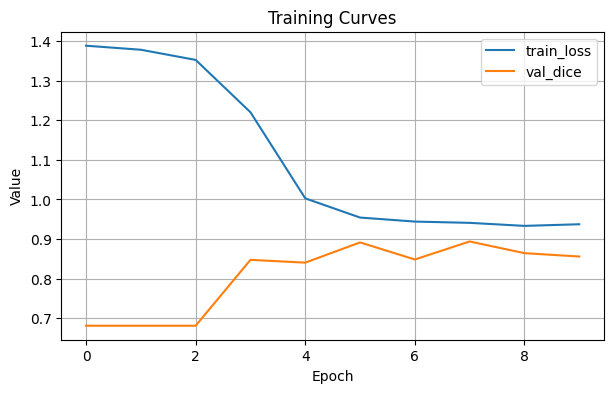

Saved plot to: /content/project/plots/training_curve.png


In [18]:
# Cell A: Plot training curves (uses `log` created during training)
import matplotlib.pyplot as plt
import os

os.makedirs('/content/project/plots', exist_ok=True)

plt.figure(figsize=(7,4))
if 'train_loss' in log:
    plt.plot(log['train_loss'], label='train_loss')
if 'val_dice' in log:
    plt.plot(log['val_dice'], label='val_dice')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Curves')
plt.grid(True)
plt.legend()
outp = '/content/project/plots/training_curve.png'
plt.savefig(outp, dpi=150, bbox_inches='tight')
plt.show()
print("Saved plot to:", outp)

In [19]:
# Cell B: load best checkpoint if you restarted; otherwise current model remains
import os, torch
best_ckpt = '/content/project/checkpoints/rd_dlf_unet_best.pth'
if os.path.exists(best_ckpt):
    model.load_state_dict(torch.load(best_ckpt, map_location=device))
    print("Loaded best checkpoint:", best_ckpt)
else:
    print("Best checkpoint not found, using current model in memory.")
model.eval()

Loaded best checkpoint: /content/project/checkpoints/rd_dlf_unet_best.pth


RobustUNet(
  (enc1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (enc2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (enc3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (up2): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
  (dec2): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (u

In [20]:
# Cell C: Inference on entire dataset, save predicted masks, overlays, and metrics CSV
import os, cv2, numpy as np, csv
os.makedirs('/content/project/outputs/pred_masks', exist_ok=True)
os.makedirs('/content/project/outputs/overlays', exist_ok=True)
os.makedirs('/content/project/results', exist_ok=True)

results = []
model.eval()
with torch.no_grad():
    for idx in range(len(dataset)):
        sample = dataset[idx]
        img_t = sample['img'][None].to(device)  # (1,1,H,W)
        gt_t1 = sample['m1'][0].numpy()         # (H,W)
        p_m0, p_delta = model(img_t)
        p_t1 = torch.clamp(p_m0 + (p_delta - 0.5), 0.0, 1.0)
        p_mask = (p_t1[0,0].cpu().numpy() > 0.5).astype('uint8') * 255

        # save predicted mask
        mask_path = f"/content/project/outputs/pred_masks/pred_{idx:04d}.png"
        cv2.imwrite(mask_path, p_mask)

        # create overlay: GT red (BGR = [0,0,255]), Pred green ([0,255,0])
        img_uint8 = (sample['img'][0].numpy() * 255).astype('uint8')
        overlay = cv2.cvtColor(img_uint8, cv2.COLOR_GRAY2BGR)
        overlay[gt_t1 > 0.5] = [0,0,255]
        overlay[p_mask > 127] = [0,255,0]
        ov_path = f"/content/project/outputs/overlays/overlay_{idx:04d}.png"
        cv2.imwrite(ov_path, overlay)

        # metrics: Dice and volume error %
        gt_bin = (gt_t1 > 0.5).astype('uint8')
        inter = ((p_mask > 127) & (gt_bin > 0)).sum()
        p_area = (p_mask > 127).sum()
        gt_area = (gt_bin > 0).sum()
        denom = p_area + gt_area + 1e-6
        dice = float(2 * inter / denom)
        vol_err_pct = float(abs(p_area - gt_area) / (gt_area + 1e-6) * 100.0)
        results.append({'idx': idx, 'dice': dice, 'vol_err_pct': vol_err_pct})

# save CSV
csv_path = '/content/project/results/results_metrics.csv'
with open(csv_path, 'w', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=['idx','dice','vol_err_pct'])
    writer.writeheader()
    writer.writerows(results)

print("Inference complete. Saved masks, overlays, and metrics CSV at:", csv_path)

Inference complete. Saved masks, overlays, and metrics CSV at: /content/project/results/results_metrics.csv


Found overlays: 358


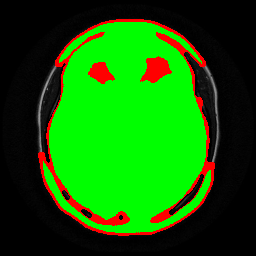

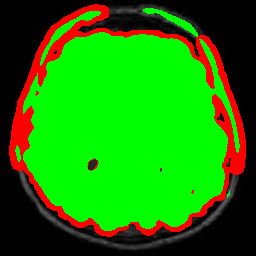

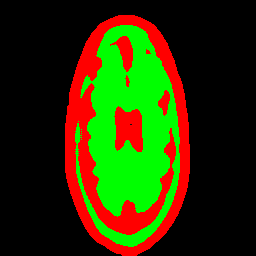

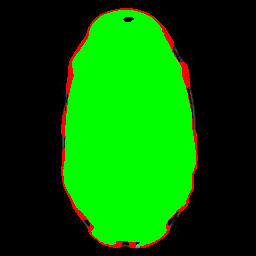

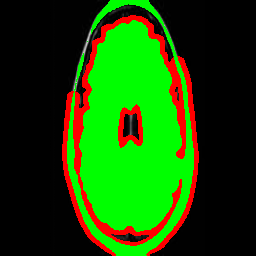

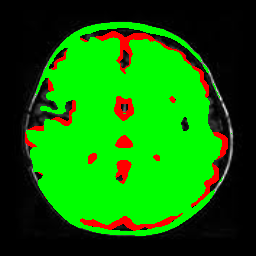

In [21]:
# Cell D: Show first 6 overlays inline
from IPython.display import display, Image
import glob
ov_list = sorted(glob.glob('/content/project/outputs/overlays/overlay_*.png'))
print("Found overlays:", len(ov_list))
for p in ov_list[:6]:
    display(Image(p))

In [22]:
# Cell E: save final model and manifest file
import json, torch, os
final_model_path = '/content/project/checkpoints/rd_dlf_unet_final.pth'
torch.save(model.state_dict(), final_model_path)
print("Saved final model to:", final_model_path)

manifest = {
    'project': 'RD-DLF Prototype',
    'model_file': final_model_path,
    'dataset_source': '/content/data (Kaggle / synthetic t1)',
    'notes': 'Prototype using synthetic t1 masks. Replace with BraTS/UPenn for real longitudinal data.',
}
with open('/content/project/manifest.json', 'w') as f:
    json.dump(manifest, f, indent=2)
print("Saved manifest at /content/project/manifest.json")

Saved final model to: /content/project/checkpoints/rd_dlf_unet_final.pth
Saved manifest at /content/project/manifest.json


In [23]:
# Cell F: copy all project outputs to Drive (if Drive is mounted)
from pathlib import Path
import shutil
DRIVE_OUT = '/content/drive/MyDrive/rd_dlf_outputs'
Path(DRIVE_OUT).mkdir(parents=True, exist_ok=True)
!rm -rf "{DRIVE_OUT}/*" 2>/dev/null || true
shutil.copytree('/content/project', DRIVE_OUT, dirs_exist_ok=True)
print("Copied project folder to Drive:", DRIVE_OUT)

Copied project folder to Drive: /content/drive/MyDrive/rd_dlf_outputs
